In [1]:
# import necessary libraries
!pip install diffusers
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from diffusers import StableDiffusionPipeline
import random
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.7 MB/s eta 0:00:00a 0:00:01


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Unified image transformations (224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
# Load dataset
data_dir = '/kaggle/input/sheep-dataset-data/SHEEP'
try:
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    class_to_label = {v: k for k, v in dataset.class_to_idx.items()}
    print(f"Dataset loaded with {len(dataset)} images.")
except FileNotFoundError:
    print(f"Dataset not found at: {data_dir}")
    exit()

Dataset loaded with 231 images.


In [49]:
# Load data in batches
# train_loader = DataLoader(dataset, batch_size=16, shuffle=True) 

In [7]:
# Check first batch (to make sure everything is working)
# first_batch = next(iter(train_loader))
# images, labels = first_batch
# print(f"Batch image shape: {images.shape}")
# print(f"Batch labels: {labels}")

In [9]:
# Visualize some images from the first batch
# def imshow(img):
#     img = img / 2 + 0.5  # Unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# Display a batch of images
# imshow(torchvision.utils.make_grid(images[:4]))  # Display first 4 images

# Print corresponding labels
# print("Labels:", labels[:4].numpy())

1. GANS

In [5]:
# Load and modify ResNet model
def load_resnet_model(model_path):
    model = torchvision.models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    # Freeze only early layers (first 5 blocks)
    freeze_blocks = list(model.children())[:5]
    for layer in freeze_blocks:
        for param in layer.parameters():
            param.requires_grad = False
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model weights loaded successfully.")
    except FileNotFoundError:
        print(f"Model weights not found at: {model_path}")
        exit()
    model.to(device)
    model.eval()
    return model

resnet_model = load_resnet_model('/kaggle/input/classification/pytorch/best_model/1/best_model.pth')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s] 


Model weights loaded successfully.


In [6]:
# Define the mean and standard deviation
mean = [0.4238, 0.3821, 0.3497]
std = [0.2922, 0.2767, 0.2695]

# Define the transforms for preprocessing the input images
transform_classifier=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.RandomRotation(58),
                               torchvision.transforms.RandomHorizontalFlip(),
#                                torchvision.transforms.RandomVerticalFlip(),
                               torchvision.transforms.Normalize(
                                 mean=mean, std=std)
                             ])

In [8]:
# Image prediction function
def predict_image(image_path, model, transform, device, threshold=0.8):
    """Predict if an image is 'Sheep' or 'Non-Sheep'."""
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Image not found at: {image_path}")
        return None
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        return 'Sheep' if output.item() > threshold else 'Non-Sheep'

In [9]:
# Path to image
image_path = '/kaggle/input/sheep-dataset-data/SHEEP/healthsheep/14-sheep-png-image-thumb.png'
predicted_class = predict_image(image_path, resnet_model, transform, device)
print('Predicted class:', predicted_class)

Predicted class: Sheep


In [28]:
# Refined RAG retrieval function
import random

def retrieve_description(health_status, dataset, class_to_label):
    """
    Retrieve a sheep health description based on health status.

    Args:
        health_status (str): 'healthy' or 'unhealthy'
        dataset (ImageFolder): The dataset object containing sheep images and labels
        class_to_label (dict): Mapping of class indices to human-readable labels

    Returns:
        str: Generated description of the sheep.
    """
    # Filter images by health status
    label_idx = 0 if health_status == 'healthy' else 1
    matching_images = [img_path for img_path, label in zip(dataset.imgs, dataset.targets) if label == label_idx]

    # Generate a dynamic description
    if health_status == 'healthy':
        description_templates = [
            "A strong, vibrant sheep with shiny wool grazing in the field.",
            "A healthy sheep with a full coat of soft wool and bright eyes.",
            "A robust sheep with a confident posture, indicative of good health."
        ]
    else:
        description_templates = [
            "A frail-looking sheep with thin, patchy wool and tired eyes.",
            "An unhealthy sheep showing signs of malnourishment and weakness.",
            "A sheep with visible signs of sickness, very weak"
        ]

    # Randomly choose a description template
    description = random.choice(description_templates)

    # Optionally, add specific image details for contextualization
    if matching_images:
        random_image_path = random.choice(matching_images)[0]
        description += f" This sheep is represented by the image at {random_image_path}."

    return description

In [11]:
# Load Stable Diffusion model
def load_stable_diffusion():
    try:
        pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
        print("Stable Diffusion model loaded successfully.")
        return pipe
    except Exception as e:
        print("Failed to load Stable Diffusion model:", str(e))
        exit()

pipe = load_stable_diffusion()

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Stable Diffusion model loaded successfully.


In [30]:
# Generate a sheep image based on health status and retrieved context
def generate_sheep_image(user_value, health_status, pipe, device):
    additional_context = retrieve_description(health_status, dataset, class_to_label)
    prompt = f"A {'healthy' if health_status == 'healthy' else 'sickly, unhealthy'} sheep. {additional_context}"
    
    with torch.no_grad():
        generated_image = pipe(prompt, guidance_scale=7.5, num_inference_steps=50).images[0]
    return generated_image

Enter a value to determine image generation characteristics (1-10):  7


  0%|          | 0/50 [00:00<?, ?it/s]

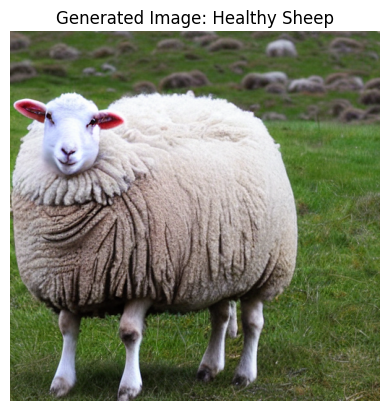

In [33]:
# User input for generating image characteristics
user_value = int(input("Enter a value to determine image generation characteristics (1-10): "))
health_status = "unhealthy" if user_value < 5 else "healthy"

# Generate and display image if classified as Sheep
if predicted_class == 'Sheep':
    generated_image = generate_sheep_image(user_value, health_status, pipe, device)
    plt.imshow(generated_image)
    plt.title(f"Generated Image: {health_status.capitalize()} Sheep")
    plt.axis('off')
    plt.show()
else:
    print("The image is not classified as a sheep.")